In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [5]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 25

# Dataset reading

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1720      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                275       
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
______________________________________________________

In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
hist = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
126/126 [==============================] - 2s 9ms/step - loss: 3.1390 - accuracy: 0.0722 - val_loss: 2.6215 - val_accuracy: 0.2217

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
126/126 [==============================] - 0s 4ms/step - loss: 2.4558 - accuracy: 0.2361 - val_loss: 1.6850 - val_accuracy: 0.4723

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
126/126 [==============================] - 1s 5ms/step - loss: 1.7122 - accuracy: 0.4101 - val_loss: 1.2066 - val_accuracy: 0.6550

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
126/126 [==============================] - 1s 5ms/step - loss: 1.3507 - accuracy: 0.5281 - val_loss: 0.9128 - val_accuracy: 0.7569

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
126/126 [==============================] - 1s 5ms/step - loss: 1.0916 - accuracy: 0.619

126/126 [==============================] - 1s 6ms/step - loss: 0.1394 - accuracy: 0.9581 - val_loss: 0.0587 - val_accuracy: 0.9884

Epoch 00037: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 38/1000
126/126 [==============================] - 1s 4ms/step - loss: 0.1366 - accuracy: 0.9588 - val_loss: 0.0563 - val_accuracy: 0.9891

Epoch 00038: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 39/1000
126/126 [==============================] - 0s 3ms/step - loss: 0.1482 - accuracy: 0.9561 - val_loss: 0.0543 - val_accuracy: 0.9899

Epoch 00039: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 40/1000
126/126 [==============================] - 0s 3ms/step - loss: 0.1335 - accuracy: 0.9624 - val_loss: 0.0557 - val_accuracy: 0.9901

Epoch 00040: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 41/1000
126/126 [==============================] - 0s 4ms/step - loss: 0.1306 - accuracy: 0.9635 - val_l

126/126 [==============================] - 1s 5ms/step - loss: 0.0777 - accuracy: 0.9769 - val_loss: 0.0344 - val_accuracy: 0.9940

Epoch 00073: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 74/1000
126/126 [==============================] - 1s 5ms/step - loss: 0.0672 - accuracy: 0.9815 - val_loss: 0.0330 - val_accuracy: 0.9944

Epoch 00074: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 75/1000
126/126 [==============================] - 1s 5ms/step - loss: 0.0699 - accuracy: 0.9787 - val_loss: 0.0339 - val_accuracy: 0.9942

Epoch 00075: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 76/1000
126/126 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.9792 - val_loss: 0.0324 - val_accuracy: 0.9942

Epoch 00076: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 77/1000
126/126 [==============================] - 1s 5ms/step - loss: 0.0712 - accuracy: 0.9806 - val_l

126/126 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9853 - val_loss: 0.0287 - val_accuracy: 0.9955

Epoch 00109: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 110/1000
126/126 [==============================] - 1s 5ms/step - loss: 0.0507 - accuracy: 0.9854 - val_loss: 0.0261 - val_accuracy: 0.9959

Epoch 00110: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 111/1000
126/126 [==============================] - 1s 4ms/step - loss: 0.0504 - accuracy: 0.9849 - val_loss: 0.0265 - val_accuracy: 0.9959

Epoch 00111: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 112/1000
126/126 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.9853 - val_loss: 0.0285 - val_accuracy: 0.9957

Epoch 00112: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 113/1000
126/126 [==============================] - 1s 4ms/step - loss: 0.0476 - accuracy: 0.9854 - v

126/126 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.9888 - val_loss: 0.0281 - val_accuracy: 0.9961

Epoch 00145: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 146/1000
126/126 [==============================] - 0s 4ms/step - loss: 0.0391 - accuracy: 0.9895 - val_loss: 0.0258 - val_accuracy: 0.9963

Epoch 00146: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 147/1000
126/126 [==============================] - 0s 3ms/step - loss: 0.0388 - accuracy: 0.9877 - val_loss: 0.0259 - val_accuracy: 0.9970

Epoch 00147: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 148/1000
126/126 [==============================] - 0s 3ms/step - loss: 0.0441 - accuracy: 0.9875 - val_loss: 0.0256 - val_accuracy: 0.9961

Epoch 00148: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 149/1000
126/126 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9885 - v

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

42/42 [==============================] - 0s 1ms/step - loss: 0.0281 - accuracy: 0.9964


In [16]:
val_acc

0.9964392781257629

In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[8.5070987e-12 5.6568688e-25 5.4729785e-19 5.3591309e-16 1.8849300e-17
 8.6023099e-15 3.8198474e-21 8.6052132e-19 2.8503982e-07 9.9999976e-01
 6.4208578e-12 8.4395261e-16 4.6418772e-13 4.2208825e-15 1.3326270e-09
 7.8404918e-18 4.2345845e-18 1.5988202e-20 9.4844311e-17 4.9877677e-08
 0.0000000e+00 4.0458880e-15 1.6340288e-26 2.3088017e-19 7.0924477e-10]
9


# Plot the results

In [31]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(154)


In [32]:
len(val_loss)

154

In [33]:
import matplotlib.pyplot as plt

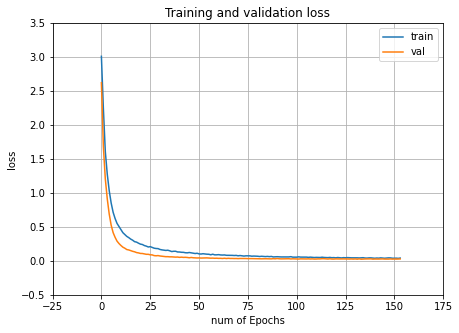

In [34]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

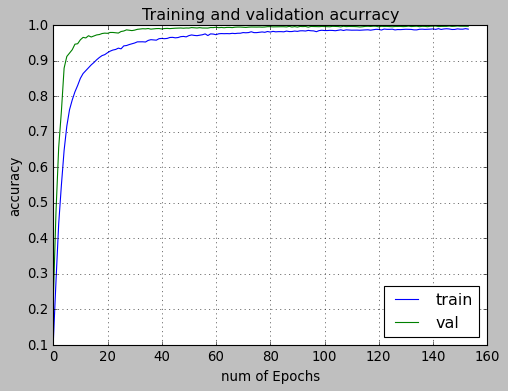

In [36]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('Training and validation acurracy')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Confusion matrix

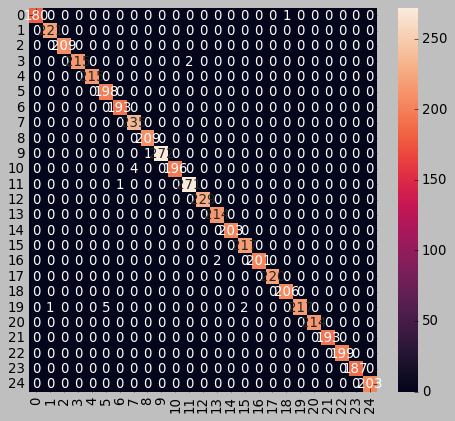

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       181
           1       1.00      1.00      1.00       221
           2       1.00      1.00      1.00       209
           3       1.00      0.99      1.00       217
           4       1.00      1.00      1.00       215
           5       0.98      1.00      0.99       198
           6       0.99      1.00      1.00       193
           7       0.98      1.00      0.99       235
           8       1.00      1.00      1.00       209
           9       1.00      1.00      1.00       273
          10       1.00      0.98      0.99       200
          11       0.99      1.00      0.99       272
          12       1.00      1.00      1.00       229
          13       0.99      1.00      1.00       214
          14       1.00      1.00      1.00       203
          15       0.99      1.00      1.00       217
          16       1.00      0.99      1.00       203
     

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Lucas\AppData\Local\Temp\tmp6j4_5kwk\assets


9456

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.4684824e-12 6.8355473e-25 5.8733287e-19 4.6314697e-16 1.5821862e-17
 1.0109082e-14 3.3421041e-21 4.9213534e-19 3.3900548e-07 9.9999964e-01
 4.5386936e-12 9.8125665e-16 4.3701815e-13 5.7923056e-15 1.1679804e-09
 7.9475116e-18 5.3055865e-18 1.1250177e-20 7.1677768e-17 4.9045045e-08
 0.0000000e+00 3.2553426e-15 1.1380628e-26 1.6260816e-19 7.2240197e-10]
9
